In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,10)
pd.options.mode.chained_assignment = None # shutdown the warning message

import simfin as sf # API for extracting company fundamentals from simfin.com website
from simfin.names import *

import yfinance as yf  # API for extracting historical stock market data from Yahoo! finance

from sklearn.linear_model import LinearRegression # package for fitting the regression model later

## Data Input

In [2]:
import simfin as sf

# the API-key for extracting data from simfin.com
sf.set_api_key('YpTs0mfqpBSBETYc1ZT2tmGp93LfeUUC')

# set the directory to store the data
sf.set_data_dir('~/simfin_data/')

# download the data from the simfin.com server with Pandas DataFrame type
df_derived = sf.load_derived(variant='quarterly', market='us')
df_income = sf.load_income(variant='quarterly-full', market='us')
df_balance = sf.load_balance(variant='quarterly-full', market='us')

# inspect the dataset
print(df_derived.loc[['AAPL', 'MSFT', 'TSLA'],'Return on Assets'])

Dataset "us-derived-quarterly" on disk (5 days old).
- Loading from disk ... Done!
Dataset "us-income-quarterly-full" on disk (5 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly-full" on disk (5 days old).
- Loading from disk ... Done!
Ticker  Report Date
AAPL    2000-06-30     0.02940
        2000-09-30     0.02499
        2000-12-31    -0.03239
        2001-03-31     0.00714
        2001-06-30     0.01013
                        ...   
TSLA    2020-03-31     0.00043
        2020-06-30     0.00273
        2020-09-30     0.00724
        2020-12-31     0.00518
        2021-03-31     0.00827
Name: Return on Assets, Length: 193, dtype: float64


In [3]:
# exclude the stocks with report date later than 2010-04-01 (to avoid output dataset contains 'nan' value)
start_date = "2010-04-01" 
condition_derived = df_derived.index.get_level_values(1) < start_date
names = df_derived[condition_derived].index.get_level_values(0) # stocks with report date earlier than 2015
df_derived = df_derived.loc[names]
df_income = df_income.loc[names]
df_balance = df_balance.loc[names]

# extract the stock info after 2010-04-01 
start_date = "2010-04-01"  
condition_derived = df_derived.index.get_level_values(1) > start_date
condition_income = df_income.index.get_level_values(1) > start_date
condition_balance = df_balance.index.get_level_values(1) > start_date
df_derived = df_derived[condition_derived]
df_income = df_income[condition_income]
df_balance = df_balance[condition_balance]

# exclude the stock info after 2020-01-01 (guarantee the sample fundamental data time frame is from June 2010 to December 2019)
end_date = "2020-01-01"  
condition_derived = df_derived.index.get_level_values(1) < end_date
condition_income = df_income.index.get_level_values(1) < end_date
condition_balance = df_balance.index.get_level_values(1) < end_date
df_derived = df_derived[condition_derived]
df_income = df_income[condition_income]
df_balance = df_balance[condition_balance]

In [4]:
# Return on assets, return on equity and earnings per share 
df_RoA = df_derived['Return on Assets'].dropna() # data of Return on Assets
df_RoE = df_derived['Return on Equity'].dropna() # data of Return on Equity
df_EPS = df_derived['Earnings Per Share, Basic'].dropna() # data of Earning Per Share

# Operating profitability 
Revenue = df_income['Revenue'].dropna()
Operating_expenses = df_income['Operating Expenses'].dropna() # negative
df_operating_profitability = Revenue - Operating_expenses # data of operating profitability

# Accruals
df_accruals = df_balance['Payables & Accruals'].dropna()

# Cash-based operating profitability
df_cash_based_op = df_operating_profitability - df_accruals
df_cash_based_op = df_cash_based_op.dropna()

# fit into dataframe
d = {'Return on assets': df_RoA, 'Return on equity': df_RoE, 'Earnings per share ': df_EPS, 'Operating profitability ': df_operating_profitability, 'Accruals': df_accruals, 'Cash-based operating profitability': df_cash_based_op}
possible_portfolio = pd.DataFrame(data=d)
possible_portfolio

Return on assets  Return on equity  Earnings per share   \
Ticker Report Date                                                            
AAP    2010-06-30            0.03032           0.09462              1.13806   
       2010-09-30            0.02581           0.07670              1.04663   
       2010-12-31            0.01434           0.04629              0.57762   
       2011-03-31            0.03067           0.12398              1.27301   
       2011-06-30            0.03139           0.14799              1.44634   
...                              ...               ...                  ...   
ZBRA   2018-12-31            0.02650           0.08614              2.14586   
       2019-03-31            0.02513           0.07839              2.13337   
       2019-06-30            0.02638           0.07954              2.29512   
       2019-09-30            0.02889           0.08028              2.51893   
       2019-12-31            0.03587           0.09190              3.13014   

                    Operating profitability       Accruals  \
Ticker Report Date                                           
AAP    2010-06-30               1.961622e+09  1.718734e+09   
       2010-09-30               1.967074e+09  1.684870e+09   
       2010-12-31               1.813678e+09  1.696199e+09   
       2011-03-31               2.670287e+09  1.960899e+09   
       2011-06-30               2.026760e+09  1.966507e+09   
...                                      ...           ...   
ZBRA   2018-12-31               1.495000e+09  9.340000e+08   
       2019-03-31               1.403000e+09  7.930000e+08   
       2019-06-30               1.452000e+09  8.140000e+08   
       2019-09-30               1.468000e+09  8.710000e+08   
       2019-12-31               1.538000e+09  9.690000e+08   

                    Cash-based operating profitability  
Ticker Report Date                                      
AAP    2010-06-30                          242888000.0  
       2010-09-30                          282204000.0  
       2010-12-31                          117479000.0  
       2011-03-31                          709388000.0  
       2011-06-30                           60253000.0  
...                                                ...  
ZBRA   2018-12-31                          561000000.0  
       2019-03-31                          610000000.0  
       2019-06-30                          638000000.0  
       2019-09-30                          597000000.0  
       2019-12-31                          569000000.0  

[14301 rows x 6 columns]

In [5]:
# S&P 500 stock info
lst = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
name = lst[0]['Symbol'] # S&P 500 stock names 
SP500 = possible_portfolio.loc[name]
SP500

Return on assets  Return on equity  Earnings per share   \
Ticker Report Date                                                            
AAP    2010-06-30            0.03032           0.09462              1.13806   
       2010-09-30            0.02581           0.07670              1.04663   
       2010-12-31            0.01434           0.04629              0.57762   
       2011-03-31            0.03067           0.12398              1.27301   
       2011-06-30            0.03139           0.14799              1.44634   
...                              ...               ...                  ...   
ZBRA   2018-12-31            0.02650           0.08614              2.14586   
       2019-03-31            0.02513           0.07839              2.13337   
       2019-06-30            0.02638           0.07954              2.29512   
       2019-09-30            0.02889           0.08028              2.51893   
       2019-12-31            0.03587           0.09190              3.13014   

                    Operating profitability       Accruals  \
Ticker Report Date                                           
AAP    2010-06-30               1.961622e+09  1.718734e+09   
       2010-09-30               1.967074e+09  1.684870e+09   
       2010-12-31               1.813678e+09  1.696199e+09   
       2011-03-31               2.670287e+09  1.960899e+09   
       2011-06-30               2.026760e+09  1.966507e+09   
...                                      ...           ...   
ZBRA   2018-12-31               1.495000e+09  9.340000e+08   
       2019-03-31               1.403000e+09  7.930000e+08   
       2019-06-30               1.452000e+09  8.140000e+08   
       2019-09-30               1.468000e+09  8.710000e+08   
       2019-12-31               1.538000e+09  9.690000e+08   

                    Cash-based operating profitability  
Ticker Report Date                                      
AAP    2010-06-30                          242888000.0  
       2010-09-30                          282204000.0  
       2010-12-31                          117479000.0  
       2011-03-31                          709388000.0  
       2011-06-30                           60253000.0  
...                                                ...  
ZBRA   2018-12-31                          561000000.0  
       2019-03-31                          610000000.0  
       2019-06-30                          638000000.0  
       2019-09-30                          597000000.0  
       2019-12-31                          569000000.0  

[8229 rows x 6 columns]

In [6]:
# SP500.to_csv(r'F:\Jupyter_Notebook file\ORIE 5370\S&P500 stock info.csv') # export csv

In [7]:
length = len(SP500.index.get_level_values(0).unique()) # number of stocks in SP500 dataset with data available before "2010-04-01"
length

211

In [8]:
# load fundamental data extracted for the selected 20 stocks: 'AAPL', 'MSFT', 'AMZN', 'GOOG', 'JNJ', 'UNH', 'V', 'NVDA', 'PG', 'MA','XOM','CMCSA','VZ','ADBE','CSCO','PFE','INTC','NFLX','KO','T'
# the fundamental data's time frame is from 2010-06-30 to 2020-12-31 and the time frame for factor model is from 2011-03-31 to 2020-12-31
SP500_20_stocks = pd.read_csv("F:\Jupyter_Notebook file\ORIE 5370\S&P 500 selected 20 stocks fundamentals.csv")
SP500_20_stocks["Report Date"] = pd.to_datetime(SP500_20_stocks["Report Date"]) # change the date to time series type
SP500_20_stocks = SP500_20_stocks.set_index(["Ticker","Report Date"])

SP500_20_stocks # used as factor loading matrix B across time

Return on assets  Return on equity  Earnings per share   \
Ticker Report Date                                                            
AAPL   2010-06-30            0.05026           0.07546              0.12736   
       2010-09-30            0.05730           0.09014              0.16823   
       2010-12-31            0.06922           0.10983              0.23325   
       2011-03-31            0.06308           0.09739              0.23161   
       2011-06-30            0.06845           0.10539              0.28182   
...                              ...               ...                  ...   
XOM    2018-12-31            0.01733           0.03022              1.40581   
       2019-03-31            0.00660           0.01187              0.55035   
       2019-06-30            0.00868           0.01577              0.73285   
       2019-09-30            0.00882           0.01608              0.74221   
       2019-12-31            0.01569           0.02860              1.33318   

                    Operating profitability      Accruals  \
Ticker Report Date                                          
AAPL   2010-06-30               1.760200e+10  12921000000   
       2010-09-30               2.240800e+10  17738000000   
       2010-12-31               2.921200e+10  20254000000   
       2011-03-31               2.701100e+10  20736000000   
       2011-06-30               3.111400e+10  22867000000   
...                                      ...          ...   
XOM    2018-12-31               7.701700e+10  37268000000   
       2019-03-31               6.962500e+10  42090000000   
       2019-06-30               7.559500e+10  41480000000   
       2019-09-30               7.170400e+10  40541000000   
       2019-12-31               7.155900e+10  41831000000   

                    Cash-based operating profitability  
Ticker Report Date                                      
AAPL   2010-06-30                           4681000000  
       2010-09-30                           4670000000  
       2010-12-31                           8958000000  
       2011-03-31                           6275000000  
       2011-06-30                           8247000000  
...                                                ...  
XOM    2018-12-31                          39749000000  
       2019-03-31                          27535000000  
       2019-06-30                          34115000000  
       2019-09-30                          31163000000  
       2019-12-31                          29728000000  

[780 rows x 6 columns]

In [9]:
# extract historical market data from Yahoo! finance 
stock_list = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'JNJ', 'UNH', 'V', 'NVDA', 'PG', 'MA','XOM','CMCSA','VZ','ADBE','CSCO','PFE','INTC','NFLX','KO','T']
stocks = yf.download(stock_list,'2010-03-30','2020-01-01') # our desired stocks in the selected time frame

[*********************100%***********************]  20 of 20 completed


In [10]:
# adjusted closing price for these stocks
stocks = stocks['Adj Close']
# stocks.to_csv(r'F:\Jupyter_Notebook file\ORIE 5370\S&P 500 selected 20 stocks Adj closing prices.csv') # export csv

In [11]:
# get expected daily net returns
n = stocks.shape[0]
stocks_return = stocks.pct_change() # net returns
stocks_return = stocks_return[1:n] # exclude the first row with NA

In [12]:
# the 20 selected stock's expected quarterly net returns as our return vector R
time_point = len(SP500_20_stocks.index.get_level_values(1).unique())
sample_date = SP500_20_stocks.index.get_level_values(1).unique()
a = []
old = stocks_return.index[0]

for i in range(time_point):
    a.append(stocks_return.loc[old:sample_date[i]].mean()*63) # 63 is the number of trading days per quarter
    old = sample_date[i] 
    
df = pd.DataFrame(a)
df = df.set_index(sample_date)
df # used as asset return vectors R across time

,AAPL,ADBE,AMZN,CMCSA,CSCO,GOOG,INTC,JNJ,KO,MA,MSFT,NFLX,NVDA,PFE,PG,T,UNH,V,VZ,XOM
Report Date,,,,,,,,,,,,,,,,,,,,
2010-06-30,0.078819,-0.279609,-0.199524,-0.055361,-0.208759,-0.225572,-0.116449,-0.080795,-0.076306,-0.212911,-0.239293,0.415406,-0.506533,-0.170666,-0.047665,-0.049030,-0.136799,-0.225915,-0.087901,-0.145064
2010-09-30,0.105322,0.006410,0.368187,0.037304,0.026885,0.151394,-0.014214,0.055104,0.155646,0.110922,0.058613,0.395928,0.133408,0.196345,0.004137,0.170915,0.207966,0.050858,0.209110,0.083914
2010-12-31,0.116798,0.177229,0.131781,0.195590,-0.057697,0.124474,0.097234,0.002208,0.117606,0.020925,0.136379,0.057976,0.264516,0.019082,0.072414,0.038205,0.034866,-0.036216,0.104688,0.174993
2011-03-31,0.080640,0.089754,-0.003183,0.123430,-0.147410,-0.016254,-0.028341,-0.033563,0.022081,0.123442,-0.082687,0.311042,0.267599,0.164739,-0.033251,0.060534,0.239277,0.054030,0.098862,0.147205
2011-06-30,-0.032459,-0.037568,0.139208,0.035123,-0.095850,-0.129220,0.094865,0.122837,0.027145,0.182095,0.025904,0.112393,-0.122551,0.026309,0.034877,0.038146,0.137108,0.141870,-0.017017,-0.027305
2011-09-30,0.140617,-0.225072,0.079371,-0.149415,0.038598,0.054728,0.018568,-0.024796,0.026474,0.061773,-0.009876,-0.757704,-0.176280,-0.128823,0.022043,-0.068694,-0.084222,0.008566,0.021454,-0.075884
2011-12-31,0.046005,0.140068,-0.219218,0.110275,0.148207,0.208855,0.109024,0.039179,0.024088,0.142517,0.033629,-0.358618,0.092390,0.200387,0.056632,0.065646,0.098310,0.157967,0.093389,0.149392
2012-03-31,0.406338,0.202305,0.172963,0.243392,0.165880,0.000636,0.161686,0.015305,0.065719,0.130462,0.232580,0.578620,0.115874,0.058714,0.017271,0.048730,0.162092,0.159945,-0.034544,0.030982
2012-06-30,-0.012217,-0.050236,0.138366,0.079071,-0.192216,-0.093126,-0.040044,0.035319,0.064104,0.032217,-0.039758,-0.479705,-0.089778,0.027138,-0.081715,0.149317,0.001354,0.057363,0.166058,-0.002469


In [13]:
# df.to_csv(r'F:\Jupyter_Notebook file\ORIE 5370\selected stocks expected quarterly net returns.csv') # export csv

##  Momentum Factor Model on Fundamentals

In [14]:
# set up model paramters 
B = SP500_20_stocks # factor loading matrix B across time, our X in regression model
R = df # asset return vectors R across time, our Y in regression model

time_point = len(B.index.get_level_values(1).unique()) # number of time points
sample_date = B.index.get_level_values(1).unique() # all the time points

In [15]:
# # test how to get our "X" in regression
# B[B.index.get_level_values(1) == "2011-03-31"]

In [16]:
# # test how to get "Y" in regression
# R.loc["2011-03-31"]

In [17]:
def momentum_factor_model(B, R, time_point, sample_date):
    '''
    Calculate the factor loading matrix B's moving average for every previous 4 quarters to account for momentum factor (interpreted 
    by each fundamental's moving average) into the fundamental factor model. Then, apply the cross-sectional regression to estimate 
    optimal factor returns matrix f by applying Ordinary Least Squares (OLS) to fit the fundamental factor model. The factor returns 
    matrix f are calculated for each quarter with respect to loading matrix B's moving average and can be used for forecasting.
    
    Args:
        B: factor loading matrix B across time, our X in regression model
        R: asset return matrix R across time, our Y in regression model
        time_point: total number of time periods
        sample_date: all the time periods
    
    Return:
        moving_average: the factor loading matrix B's moving average 
        f_fit: fitted factor returns matrix f by Ordinary Least Squares (OLS) with respect to moving_average at each time point
    
    '''
    
    # new dataframe to store moving average of fundamentals
    moving_average = B[B.index.get_level_values(1) >= sample_date[3]].copy()
    for ticker in B.index.get_level_values(0).unique():
        for i in range(3, time_point): # factor loading matrix B's moving average every frequency period (i.e. previous 4 quarters)
            moving_average.loc[ticker].loc[sample_date[i]] = (B.loc[ticker].loc[sample_date[i]] \
                                                       + B.loc[ticker].loc[sample_date[i - 1]] \
                                                       + B.loc[ticker].loc[sample_date[i - 2]] \
                                                       + B.loc[ticker].loc[sample_date[i - 3]]) / 4
            
    # new dataframe to store the fitted factor returns matrix f across time
    f_fit = pd.DataFrame(columns = B.columns.tolist(), index = sample_date[3:])
    
    for date in f_fit.index.tolist():
        model = LinearRegression().fit(moving_average[moving_average.index.get_level_values(1) == date], R.loc[date]) # fit the 
# regression model by applying Ordinary Least Squares optimization to each rebalanced company fundamentals 
        f_fit.loc[date] = model.coef_ # store the optimal factor returns vector f for each quarter
    
    f_fit # factor return matrix f fitted across the time
    
    return moving_average, f_fit

In [18]:
# here, we calculate the company fundamentals' moving average for every previous 4 quarters including the current one
# we calculate the factor loading matrix B's moving average every 4 quarters to account for momentum factor (interpreted by each 
# fundamental's moving average) into our fundamental model
moving_average, f_fit = momentum_factor_model(B, R, time_point, sample_date)
moving_average

Return on assets  Return on equity  Earnings per share   \
Ticker Report Date                                                            
AAPL   2011-03-31           0.059965          0.093205             0.190112   
       2011-06-30           0.064513          0.100687             0.228728   
       2011-09-30           0.064415          0.099765             0.250362   
       2011-12-31           0.070660          0.108575             0.317333   
       2012-03-31           0.074140          0.112575             0.370580   
...                              ...               ...                  ...   
XOM    2018-12-31           0.014895          0.026548             1.220165   
       2019-03-31           0.013212          0.023550             1.085505   
       2019-06-30           0.012553          0.022390             1.037507   
       2019-09-30           0.010358          0.018485             0.857805   
       2019-12-31           0.009947          0.018080             0.839647   

                    Operating profitability      Accruals  \
Ticker Report Date                                          
AAPL   2011-03-31               2.405825e+10  20736000000   
       2011-06-30               2.743625e+10  22867000000   
       2011-09-30               2.956925e+10  23879000000   
       2011-12-31               3.469025e+10  29721000000   
       2012-03-31               3.852900e+10  26789000000   
...                                      ...          ...   
XOM    2018-12-31               7.807700e+10  37268000000   
       2019-03-31               7.716400e+10  42090000000   
       2019-06-30               7.614325e+10  41480000000   
       2019-09-30               7.348525e+10  40541000000   
       2019-12-31               7.212075e+10  41831000000   

                    Cash-based operating profitability  
Ticker Report Date                                      
AAPL   2011-03-31                           6275000000  
       2011-06-30                           8247000000  
       2011-09-30                           7061000000  
       2011-12-31                          19975000000  
       2012-03-31                          15577000000  
...                                                ...  
XOM    2018-12-31                          39749000000  
       2019-03-31                          27535000000  
       2019-06-30                          34115000000  
       2019-09-30                          31163000000  
       2019-12-31                          29728000000  

[720 rows x 6 columns]

In [19]:
# the goal of the cross-sectional regression is to estimate optimal factor returns f by applying Ordinary Least Squares (OLS)
# fit the fundamental factor model at each quarter with respect to the loading matrix B's moving average
f_fit # factor return matrix f fitted across time

,Return on assets,Return on equity,Earnings per share,Operating profitability,Accruals,Cash-based operating profitability
Report Date,,,,,,
2011-03-31,-6.60293,2.36836,3.77896e-05,-2.73009e-11,2.37241e-11,2.63954e-11
2011-06-30,0.086285,0.694781,-0.00676786,1.13303e-11,-9.99156e-12,-1.09079e-11
2011-09-30,10.3586,-5.6246,0.0055171,7.06211e-12,-2.42818e-12,-8.33176e-12
2011-12-31,7.85638,-4.4912,0.0065159,7.3047e-12,-1.23451e-11,-1.65503e-12
2012-03-31,-5.62595,4.95331,-0.022772,-4.84715e-11,4.7668e-11,4.67444e-11
2012-06-30,8.4073,-6.93922,-0.0205735,-2.11587e-11,2.76803e-11,2.18926e-11
2012-09-30,0.497197,-1.18079,0.0359291,1.36605e-11,-8.78078e-12,-1.76547e-11
2012-12-31,-2.15709,-0.752974,-0.0293033,1.83623e-11,-1.71338e-11,-2.21639e-11
2013-03-31,-10.9245,3.80764,0.019105,1.93117e-11,-2.22808e-11,-2.3195e-11


In [20]:
# new dataframe to store our predicted stock expected returns
expected_return = pd.DataFrame(columns = R.columns.tolist(), index = f_fit.index)
# expected_return

In [21]:
# the predicted stock expected net returns by multiplying factor loading matrix B's moving average and the fitted factor return matrix f
for ticker in expected_return.columns.tolist():
    expected_return[ticker] = (moving_average.loc[ticker] * f_fit).sum(axis = 1)
expected_return # predicted quarterly expected net returns

,AAPL,ADBE,AMZN,CMCSA,CSCO,GOOG,INTC,JNJ,KO,MA,MSFT,NFLX,NVDA,PFE,PG,T,UNH,V,VZ,XOM
Report Date,,,,,,,,,,,,,,,,,,,,
2011-03-31,-0.174432,-0.081150,-0.025221,-0.091356,-0.078856,-0.127496,-0.160509,-0.116073,-0.072055,-0.158780,-0.178808,0.135732,-0.050440,-0.064409,-0.097778,-0.141931,-0.023395,-0.090776,-0.079023,-0.014784
2011-06-30,0.066402,0.031949,0.034707,0.037282,0.035579,-0.014144,0.042029,0.042786,0.055384,0.048589,0.090356,0.138429,0.012416,0.030924,0.057449,0.077479,0.037657,0.026621,0.027300,-0.034704
2011-09-30,0.199499,0.050414,-0.008455,0.036006,0.001420,0.167688,0.128687,0.078293,-0.077896,0.100696,0.005950,-0.582948,0.080123,-0.009629,0.035597,0.041390,-0.059475,0.084929,-0.003446,0.087114
2011-12-31,-0.076998,0.027853,-0.113865,-0.048034,0.042442,0.145062,0.089134,-0.041899,-0.080186,0.035515,0.050574,-0.432854,0.065692,0.022961,-0.034987,0.004188,0.040244,0.051296,0.057863,0.071552
2012-03-31,0.269628,0.032781,0.054149,-0.027845,0.033486,-0.147899,0.020929,0.005059,0.097562,0.067430,0.080613,0.389994,0.018091,0.011114,0.002241,-0.142425,0.116731,0.021344,-0.101112,-0.092396
2012-06-30,-0.004648,-0.050000,0.009786,-0.028532,-0.060661,-0.100345,-0.053936,0.015979,-0.150360,-0.190539,-0.087626,-0.284769,-0.018762,-0.059835,-0.072936,0.043763,-0.111118,0.115476,0.056971,0.046723
2012-09-30,0.101528,-0.014427,0.045607,0.045717,-0.057364,0.228614,-0.047880,0.054557,-0.031708,-0.047921,-0.033895,-0.020380,-0.018836,-0.027730,0.027367,0.044801,-0.073506,0.040334,-0.016080,0.073869
2012-12-31,-0.486637,-0.089538,-0.134850,-0.076678,-0.140295,-0.256005,-0.174346,-0.139237,-0.129728,-0.221979,-0.270027,-0.011151,-0.080920,-0.117800,-0.185769,-0.250487,-0.238897,-0.042884,-0.245890,-0.301786
2013-03-31,-0.465048,-0.093405,-0.068607,-0.068894,-0.163258,-0.154728,-0.203260,-0.147231,-0.042675,-0.246660,-0.267927,0.007843,-0.138964,-0.083916,-0.149864,-0.108132,-0.175083,-0.096239,-0.115625,-0.342095


Text(0, 0.5, 'Quarterly expected returns')

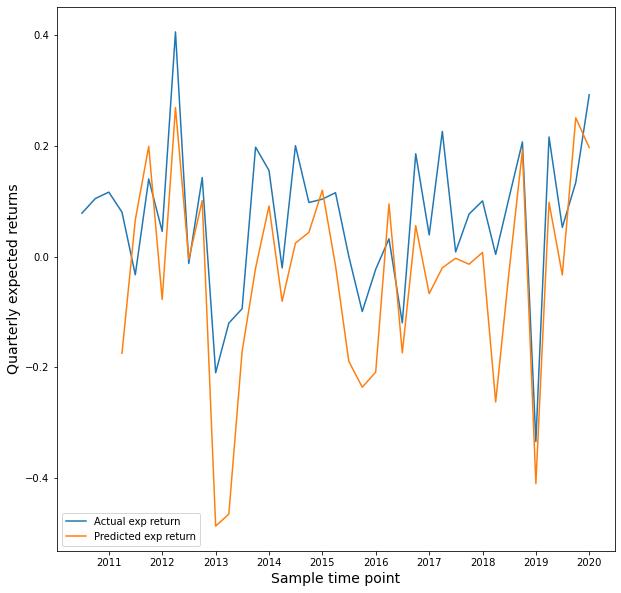

In [22]:
# plot the prediction v.s. the actual stock expected quarterly net returns (almost follows the same trend!!)
plt.plot(R.index, R["AAPL"])
plt.plot(expected_return.index, expected_return["AAPL"])
plt.legend(['Actual exp return', 'Predicted exp return'],loc = "lower left")
plt.xlabel('Sample time point', size = 14)
plt.ylabel('Quarterly expected returns', size = 14)

##  Markowitz Portfolio Optimization with `cvxpy`

Long only Markowitz Optimization setup
\begin{equation*}
\begin{aligned}
& \underset{w}{\text{maximize}}
& & \mu^T w - \frac{1}{2}\gamma w^T \Sigma w, \; w \geq 0 \\
& \text{subject to}
& & e^T w = 1, \\
&&& \text{abs}(w) \leq 0.5,
\end{aligned}
\end{equation*}


In [23]:
# load optimization package cvxpy
import cvxpy as cp

num_asset = len(R.columns.unique()) # number of selected stocks
sample_asset = R.columns.unique() # name of the tickers

In [24]:
# projecting daily covariances to quarterly covariances according to lecture note...
# first, get the daily expected log returns
stocks_log_return = stocks_return.apply(lambda x: np.log(1+x)) # transforming the net returns to log returns
stocks_log_return

,AAPL,ADBE,AMZN,CMCSA,CSCO,GOOG,INTC,JNJ,KO,MA,MSFT,NFLX,NVDA,PFE,PG,T,UNH,V,VZ,XOM
Date,,,,,,,,,,,,,,,,,,,,
2010-03-31,-0.003610,-0.008726,-0.005948,0.004791,-0.023540,0.000723,-0.002240,0.004612,0.002366,0.006279,-0.016255,-0.017742,-0.013132,-0.006394,-0.006145,-0.004248,-0.011867,0.000330,-0.006747,-0.001045
2010-04-01,0.004119,0.010407,-0.029601,0.001592,-0.007713,0.002958,0.004476,0.008705,0.005440,-0.000236,-0.004448,0.016943,-0.010399,-0.004089,0.001421,0.010395,0.010666,0.016560,0.008347,0.009362
2010-04-05,0.010623,0.006971,-0.002431,0.002926,0.013077,0.003878,0.008893,-0.005641,-0.007988,0.006437,0.003766,0.064414,0.014986,-0.010595,0.006293,0.007631,0.004536,-0.000864,0.005738,0.008542
2010-04-06,0.004393,-0.008090,0.030483,-0.003193,0.001908,-0.004898,-0.008446,-0.001377,-0.010445,0.012327,0.001707,0.041387,-0.024907,0.003544,-0.010247,0.000000,0.008114,-0.000758,-0.008299,-0.004262
2010-04-07,0.004415,-0.018090,-0.005103,-0.025373,0.004566,-0.008270,0.002230,-0.001379,-0.008695,-0.011434,0.001023,-0.044643,0.006431,0.006465,-0.009712,-0.009314,-0.014471,-0.018459,-0.015911,-0.008282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.000950,0.002095,-0.002116,0.009703,-0.006675,-0.003922,0.003034,-0.003489,-0.003649,0.000706,-0.000191,0.000300,-0.000838,-0.000763,0.002559,-0.002820,-0.001866,0.002616,-0.001956,-0.003849
2019-12-26,0.019646,0.004721,0.043506,0.009833,0.001464,0.012456,0.006878,-0.000685,0.005650,0.005765,0.008163,-0.001712,0.002386,0.002288,0.000000,0.005121,0.003762,0.008441,0.000163,0.001570
2019-12-27,-0.000380,-0.001239,0.000551,0.002886,-0.001673,-0.006275,0.004337,-0.000549,0.005980,0.005134,0.001826,-0.010700,-0.009747,-0.001525,0.006924,0.002041,0.001082,0.001215,0.003908,-0.003428


In [25]:
# get log return covariance matrix in first quarter by using daily log returns
covariance = stocks_log_return.loc["2010-12-31":"2011-03-31"].cov()

In [26]:
# get log return covariance matrix in first quarter by rebalancing to the length of horizon (i.e. quarterly)
covariance = covariance*63 # 63 is the number of trading days per quarter

In [27]:
# get the expected compounded returns in first quarter
compounded_returns = stocks_log_return.loc["2010-12-31":"2011-03-31"].mean()*63

In [28]:
# get the expected gross returns in first quarter from the expected compounded returns
gross_returns = np.exp(compounded_returns + 1/2*np.diag(covariance))

In [29]:
# get the covariance matrix in first quarter to be used into our example
covariance = (gross_returns@gross_returns.T) * (np.exp(covariance)-1)
covariance

,AAPL,ADBE,AMZN,CMCSA,CSCO,GOOG,INTC,JNJ,KO,MA,MSFT,NFLX,NVDA,PFE,PG,T,UNH,V,VZ,XOM
AAPL,0.322132,0.205964,0.139733,0.158334,0.144874,0.133008,0.092618,0.056949,0.064871,0.105534,0.122553,0.060439,0.325697,0.122819,0.047890,0.078711,0.087530,0.093336,0.122021,0.105531
ADBE,0.205964,0.408351,0.208692,0.192355,0.063392,0.147956,0.140175,0.066562,0.071665,0.137989,0.118433,0.022601,0.453074,0.110433,0.028023,0.101780,0.138229,0.144277,0.105292,0.074543
AMZN,0.139733,0.208692,0.550820,0.106809,0.096535,0.199486,0.095365,0.046333,0.046870,0.142213,0.153442,0.311425,0.253365,0.092296,-0.003174,0.098594,0.244340,0.151311,0.078197,0.060979
CMCSA,0.158334,0.192355,0.106809,0.292542,0.028063,0.127998,0.089255,0.093940,0.066750,0.052182,0.097374,-0.073281,0.238606,0.142366,0.059999,0.098160,0.119688,0.094040,0.114215,0.117358
CSCO,0.144874,0.063392,0.096535,0.028063,0.715767,0.094973,0.036684,0.024124,0.021124,0.043021,0.147667,-0.005065,0.344674,0.082284,0.021441,0.033559,0.069173,0.023522,0.095153,0.051617
GOOG,0.133008,0.147956,0.199486,0.127998,0.094973,0.201486,0.059265,0.047874,0.048876,0.082389,0.121261,0.076732,0.239181,0.086799,0.042306,0.075331,0.129200,0.103029,0.067818,0.096455
INTC,0.092618,0.140175,0.095365,0.089255,0.036684,0.059265,0.194085,0.022145,0.055815,0.113016,0.071595,0.000873,0.257625,0.051724,0.037935,0.061171,0.071894,0.117799,0.054094,0.047134
JNJ,0.056949,0.066562,0.046333,0.093940,0.024124,0.047874,0.022145,0.087991,0.013692,0.006254,0.041187,-0.036876,0.076574,0.070375,0.032300,0.053499,0.063636,0.025939,0.083336,0.053067
KO,0.064871,0.071665,0.046870,0.066750,0.021124,0.048876,0.055815,0.013692,0.102035,0.023149,0.040886,-0.044786,0.098921,0.029087,0.029255,0.049921,0.027168,0.037081,0.034717,0.034238
MA,0.105534,0.137989,0.142213,0.052182,0.043021,0.082389,0.113016,0.006254,0.023149,0.229727,0.080507,0.006898,0.286656,0.049799,0.036090,0.065082,0.084113,0.170347,0.025884,0.045171


In [30]:
mu = expected_return.loc["2011-03-31"] # the predicted expected returns at first quarter
mu

AAPL    -0.174432
ADBE    -0.081150
AMZN    -0.025221
CMCSA   -0.091356
CSCO    -0.078856
GOOG    -0.127496
INTC    -0.160509
JNJ     -0.116073
KO      -0.072055
MA      -0.158780
MSFT    -0.178808
NFLX     0.135732
NVDA    -0.050440
PFE     -0.064409
PG      -0.097778
T       -0.141931
UNH     -0.023395
V       -0.090776
VZ      -0.079023
XOM     -0.014784
Name: 2011-03-31 00:00:00, dtype: float64

In [31]:
# assume risk aversion coefficient 𝛾 = 2
# check the optimal solution at first quarter
w = cp.Variable(num_asset, nonneg=True) # weights greater than 0 (only long position allowed)
𝛾 = cp.Parameter(nonneg=True, value = 2) # risk aversion coefficient 𝛾
mu = np.array(mu) 
covariance = np.array(covariance)
port_return = mu.T@w # portfolio return at this time point
port_variance = cp.quad_form(w,covariance) # portfolio variance 𝑤.TΣ𝑤 at this time point
objective = cp.Maximize(port_return - 1/2*𝛾*port_variance) # perform optimization by cvxpy
constraint = [cp.sum(w) == 1, cp.abs(w) <= 0.5] 
prob = cp.Problem(objective,constraint)
prob.solve() # returns the optimal value
['{:f}'.format(i) for i in w.value] # optimal weight for each asset
# prob.status # check if reach the optimal
# port_return.value # optimal portfolio return

['0.000000',
 '0.000000',
 '0.000000',
 '0.000000',
 '0.012212',
 '0.000000',
 '0.000000',
 '0.000000',
 '0.292876',
 '0.000000',
 '0.000000',
 '0.131953',
 '0.000000',
 '0.000754',
 '0.258204',
 '0.000000',
 '0.043400',
 '0.000000',
 '0.051053',
 '0.209549']

In [32]:
def project_quarterly_covariance(start_date,end_date):
    '''
    Projecting daily compounded log returns to quarterly simple returns and output the corresponding projected and invertible quarterly 
    covariance matrix.
    
    Args:
        start_date: the first date of the current time period
        end_date: the last date of the current time period
        
    Returns:
        covariance: projected quarterly covariance matrix
    '''
        
    # get log return covariance matrix in current quarter by using daily log returns
    covariance = stocks_log_return.loc[start_date:end_date].cov()
    # get log return covariance matrix in current quarter by rebalancing to the length of horizon (i.e. quarterly)
    covariance = covariance*63 # 63 is the number of trading days per quarter
    # get the expected compounded returns in current quarter
    compounded = stocks_log_return.loc[start_date:end_date].mean()*63
    # get the expected gross returns in current quarter from the expected compounded returns
    gross_returns = np.exp(compounded_returns + 1/2*np.diag(covariance))
    # get the covariance matrix in current quarter to be used in our example
    covariance = (gross_returns@gross_returns.T) * (np.exp(covariance)-1)
    
    return covariance # output the quarterly projected covariance matrix

In [33]:
# # test the function "project_quarterly_covariance()"
# project_quarterly_covariance("2010-12-31","2011-03-31") # same as the covariance matrix obtained above

In [34]:
# assume risk aversion coefficient 𝛾 = 2
# construct the optimized portfolio with optimal weights to each selected asset at each period
port_volatility_data = [] # optimized portfolio volatility for each quarter
port_return_data = [] # optimized portfolio return for each quarter
port_optimal_weight = [] # optimal portfolio weight for each quarter
port_sharpe_ratio = [] # optimal portfolio's sharpe ratio for each quarter
for i in range(3, time_point):
    date = sample_date[i]
    mu = np.array(expected_return.loc[date]) # expected returns at current time
    covariance = np.array(project_quarterly_covariance(sample_date[i-1],sample_date[i])) # projected covariance matrix in current time period
    w = cp.Variable(num_asset, nonneg=True) # weights greater than 0 (only long position allowed)
    𝛾 = cp.Parameter(nonneg=True, value = 2) # risk aversion coefficient 𝛾
    port_return = mu.T @ w # portfolio return at current time
    port_variance = cp.quad_form(w, covariance) # portfolio variance 𝑤.TΣ𝑤 at current time
    objective = cp.Maximize(port_return - 1/2*𝛾*port_variance)
    constraint = [cp.sum(w) == 1, cp.abs(w) <= 0.5] 
    prob = cp.Problem(objective, constraint) # Markowitz setup optimization
    prob.solve()
    port_volatility_data.append(cp.sqrt(port_variance).value) 
    port_return_data.append(port_return.value)
#     print(prob.status) # check if reach the optimal solution
    port_optimal_weight.append(['{:f}'.format(i) for i in w.value]) # weights for each asset at each period

In [35]:
# The optimal portfolio weight quarterly
port_optimal_weight = pd.DataFrame(port_optimal_weight, columns = R.columns.tolist(),index = f_fit.index)
port_optimal_weight
# port_optimal_weight.to_csv(r'F:\Jupyter_Notebook file\ORIE 5370\Optimal portfolio weights adjusted quarterly.csv') # export csv

,AAPL,ADBE,AMZN,CMCSA,CSCO,GOOG,INTC,JNJ,KO,MA,MSFT,NFLX,NVDA,PFE,PG,T,UNH,V,VZ,XOM
Report Date,,,,,,,,,,,,,,,,,,,,
2011-03-31,0.000000,0.000000,0.000000,0.000000,0.012212,0.000000,0.000000,0.000000,0.292876,0.000000,0.000000,0.131953,0.000000,0.000754,0.258204,0.000000,0.043400,0.000000,0.051053,0.209549
2011-06-30,0.038583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194698,0.000000,0.079302,0.114911,0.000000,0.000000,0.366757,0.205751,0.000000,0.000000,0.000000,0.000000
2011-09-30,0.197149,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.302877,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.499981,0.000000,0.000000,0.000000,0.000000,0.000000
2011-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.178859,0.000000,0.000001,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.256351,0.064752,0.000000,0.000001,0.500037,0.000000
2012-03-31,0.341340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.499994,0.000000,0.017653,0.077409,0.000000,0.000000,0.000000,0.000000,0.063626,0.000000,0.000000,0.000000
2012-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.348467,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013582,0.000000,0.137950,0.500002,0.000000
2012-09-30,0.092317,0.000000,0.000000,0.000000,0.000000,0.499999,0.000000,0.379513,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028171
2012-12-31,0.000000,0.146366,0.000000,0.012680,0.015097,0.000000,0.000000,0.068099,0.079892,0.000001,0.000000,0.019424,0.025863,0.271698,0.000001,0.000000,0.000001,0.360875,0.000001,0.000001
2013-03-31,0.000000,0.031732,0.067895,0.094501,0.000000,0.000000,0.000000,0.058983,0.409150,0.000000,0.000000,0.023817,0.000000,0.000000,0.000000,0.000000,0.000000,0.053334,0.260589,0.000000


In [36]:
# The optimal portfolio returns quarterly
port_return_data = pd.DataFrame(port_return_data, columns = {"Portfolio returns"},index = f_fit.index)
port_return_data

,Portfolio returns
Report Date,
2011-03-31,-0.037599
2011-06-30,0.073429
2011-09-30,0.080842
2011-12-31,0.046182
2012-03-31,0.179854
2012-06-30,0.050578
2012-09-30,0.146466
2012-12-31,-0.085834
2013-03-31,-0.075354


In [37]:
# construct the benchmark portfolio with equal weights assigned to each selected asset at each time point
benchmark_port_volatility_data = [] # benchmark portfolio volatility for each quarter
benchmark_port_return_data = [] # benchmark portfolio return for each quarter
for i in range(3, time_point):
    date = sample_date[i]
    mu = np.array(expected_return.loc[date]) # expected returns at current time
    covariance = np.array(project_quarterly_covariance(sample_date[i-1],sample_date[i])) # projected covariance matrix in current time period
    w = np.array([1/num_asset for i in range(num_asset)]) # weights equally separated
    port_return = mu.T @ w # portfolio returns at current time
    port_variance = w.T@covariance@w # portfolio variance 𝑤.TΣ𝑤 at current time
    benchmark_port_volatility_data.append(np.sqrt(port_variance))
    benchmark_port_return_data.append(port_return)

Text(0, 0.5, 'Quarterly expected returns')

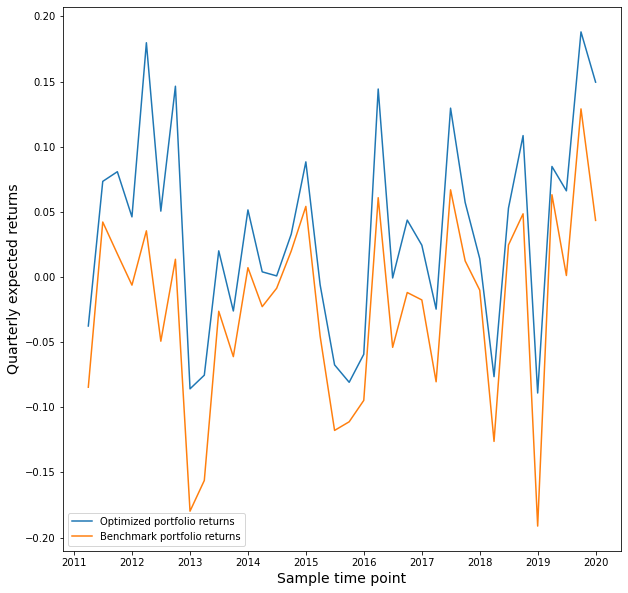

In [38]:
# plot the optimized portfolio expected quarterly returns v.s. the benchmark portfolio expected quarterly returns
# clearly, our optimized portfolio returns are strictly larger than the benchmark portfolio returns at every period!!
plt.plot(expected_return.index, port_return_data)
plt.plot(R.index[3:], benchmark_port_return_data) # compare with our benchmark portfolio 
plt.legend(['Optimized portfolio returns', 'Benchmark portfolio returns'],loc = "lower left")
plt.xlabel('Sample time point', size = 14)
plt.ylabel('Quarterly expected returns', size = 14)

Text(0, 0.5, 'Portfolio  volatility')

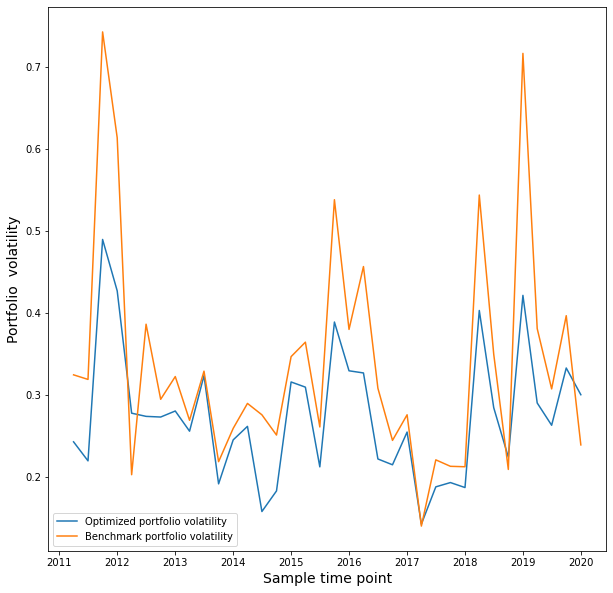

In [39]:
# plot the optimized portfolio's volatility v.s. the benchmark portfolio's volatility at each time point
# clearly, the optimized portfolio has relatively lower volatility than the benchmark portfolio at most time points
plt.plot(expected_return.index, port_volatility_data)
plt.plot(R.index[3:], benchmark_port_volatility_data) # compare with our benchmark portfolio 
plt.legend(['Optimized portfolio volatility', 'Benchmark portfolio volatility'],loc = "lower left")
plt.xlabel('Sample time point', size = 14)
plt.ylabel('Portfolio  volatility', size = 14)